In [1]:
import os

os.environ["BRASA_DATA_PATH"] = "/mnt/d/brasa"

In [2]:
import sys
sys.path.append('..')

from datetime import datetime

import numpy as np
import pandas as pd
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow
import statsmodels.api as sm

import brasa
from bcb import PTAX

In [3]:
ptax = PTAX()
ptax.get_endpoint("Moedas").query().collect()

,simbolo,nomeFormatado,tipoMoeda
0,AUD,Dólar australiano,B
1,CAD,Dólar canadense,A
2,CHF,Franco suíço,A
3,DKK,Coroa dinamarquesa,A
4,EUR,Euro,B
5,GBP,Libra Esterlina,B
6,JPY,Iene,A
7,NOK,Coroa norueguesa,A
8,SEK,Coroa sueca,A
9,USD,Dólar dos Estados Unidos,A


In [4]:
ptax.describe("CotacaoMoedaPeriodo")


Function: CotacaoMoedaPeriodo
Parameters: moeda <str>, dataInicial <str>, dataFinalCotacao <str>
EntitySet: _CotacaoMoedaPeriodo
EntityType: br.gov.bcb.olinda.servico.PTAX.TipoCotacaoMoeda
Properties: paridadeCompra <float>, paridadeVenda <float>, cotacaoCompra <float>, cotacaoVenda <float>, dataHoraCotacao <str>, tipoBoletim <str>


In [5]:
ptax.get_endpoint("CotacaoMoedaPeriodo").query().parameters(dataInicial="4/1/2024", dataFinalCotacao="4/12/2024", moeda="EUR").collect()["dataHoraCotacao"].dt.strftime("%Y-%m-%d")

0     2024-04-01
1     2024-04-01
2     2024-04-01
3     2024-04-01
4     2024-04-01
5     2024-04-02
6     2024-04-02
7     2024-04-02
8     2024-04-02
9     2024-04-02
10    2024-04-03
11    2024-04-03
12    2024-04-03
13    2024-04-03
14    2024-04-03
15    2024-04-04
16    2024-04-04
17    2024-04-04
18    2024-04-04
19    2024-04-04
20    2024-04-05
21    2024-04-05
22    2024-04-05
23    2024-04-05
24    2024-04-05
25    2024-04-08
26    2024-04-08
27    2024-04-08
28    2024-04-08
29    2024-04-08
30    2024-04-09
31    2024-04-09
32    2024-04-09
33    2024-04-09
34    2024-04-09
35    2024-04-10
36    2024-04-10
37    2024-04-10
38    2024-04-10
39    2024-04-10
40    2024-04-11
41    2024-04-11
42    2024-04-11
43    2024-04-11
44    2024-04-11
45    2024-04-12
46    2024-04-12
47    2024-04-12
48    2024-04-12
49    2024-04-12
Name: dataHoraCotacao, dtype: object

In [6]:
ptax.get_endpoint("CotacaoMoedaDia").query().parameters(dataCotacao  = "4/12/2023", moeda = "EUR").collect()

,paridadeCompra,paridadeVenda,cotacaoCompra,cotacaoVenda,dataHoraCotacao,tipoBoletim
0,1.0964,1.0965,5.4545,5.4556,2023-04-12 10:09:17.351,Abertura
1,1.0973,1.0977,5.4270,5.4297,2023-04-12 11:02:17.545,Intermediário
2,1.0976,1.0977,5.4178,5.4189,2023-04-12 12:05:17.242,Intermediário
3,1.0984,1.0986,5.4254,5.4271,2023-04-12 13:06:18.927,Intermediário
4,1.0984,1.0986,5.4360,5.4376,2023-04-12 13:06:18.938,Fechamento PTAX


In [7]:
moedas = ptax.get_endpoint("Moedas").query().collect()

In [8]:
moedas

,simbolo,nomeFormatado,tipoMoeda
0,AUD,Dólar australiano,B
1,CAD,Dólar canadense,A
2,CHF,Franco suíço,A
3,DKK,Coroa dinamarquesa,A
4,EUR,Euro,B
5,GBP,Libra Esterlina,B
6,JPY,Iene,A
7,NOK,Coroa norueguesa,A
8,SEK,Coroa sueca,A
9,USD,Dólar dos Estados Unidos,A


In [9]:
[moeda for moeda in moedas.query("tipoMoeda == 'A'")["simbolo"]]

['CAD', 'CHF', 'DKK', 'JPY', 'NOK', 'SEK', 'USD']

<Axes: xlabel='refdate'>

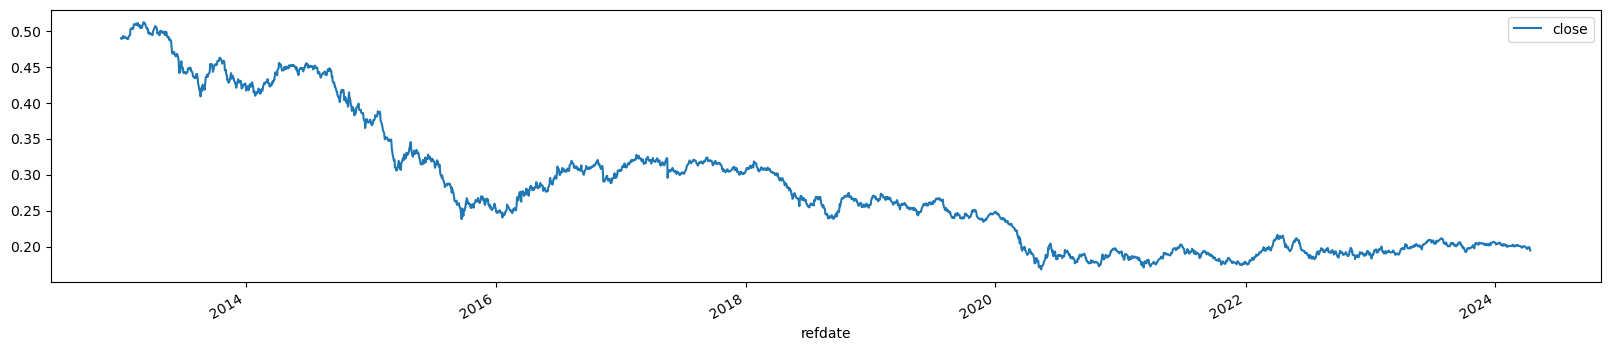

In [10]:
(brasa.get_dataset("bcb-currency-data")
 .filter(pc.field("symbol") == "BRLUSD")
 .filter(pc.field("refdate") >= datetime(2013, 1, 1))
 .filter(pc.field("refdate") <= datetime.today())
 .to_table()
 .to_pandas()
).plot(x="refdate", y="close", figsize=(20, 4))

<Axes: xlabel='refdate'>

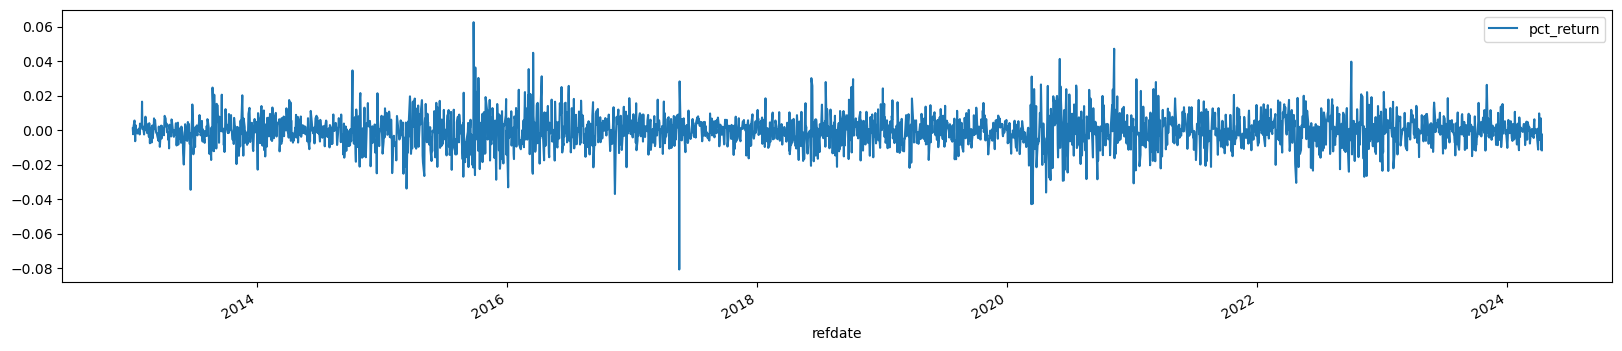

In [11]:
(brasa.get_dataset("bcb-currencies-returns")
 .filter(pc.field("symbol") == "BRLUSD")
 .filter(pc.field("refdate") >= datetime(2013, 1, 1))
 .filter(pc.field("refdate") <= datetime.today())
 .to_table()
 .to_pandas()
).plot(x="refdate", y="pct_return", figsize=(20, 4))

In [ ]:

ep = ptax.get_endpoint('CotacaoDolarPeriodo')
usd = (ep.query()
 .parameters(dataInicial = "4/1/2023", dataFinalCotacao = "3/31/2024")
 .select(ep.dataHoraCotacao, ep.cotacaoVenda)
 .collect()
 )
usd.dataHoraCotacao = pd.to_datetime(pd.to_datetime(usd.dataHoraCotacao).dt.date)
usd = usd.set_index("dataHoraCotacao").rename(columns={"cotacaoVenda": "USDBRL"})

symbol = "SUZB3"
etf = brasa.get_prices(symbol, start=datetime(2023, 4, 1), end=datetime(2024,3,31))

df = (pd.concat([etf, usd], axis=1)
      .dropna()
      .pct_change()
      .dropna()
      .sort_index())

sm.OLS(df[symbol], sm.add_constant(df["USDBRL"])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SUZB3   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3217
Date:                Sat, 13 Apr 2024   Prob (F-statistic):              0.571
Time:                        18:04:55   Log-Likelihood:                 679.54
No. Observations:                 245   AIC:                            -1355.
Df Residuals:                     243   BIC:                            -1348.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.895      0.059   -7.25e-05       0.004
USDBRL        -0.0877      0.155     -0.567      0.571      -0.392       0.217
==============================================================================
Omnibus:                        5.520   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.063   Jarque-Bera (JB):                5.320
Skew:                           0.292   Prob(JB):                       0.0700
Kurtosis:                       3.423   Cond. No.                         160.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
ptax = PTAX()
ep = ptax.get_endpoint('CotacaoDolarPeriodo')
usd = (ep.query()
 .parameters(dataInicial = "3/1/2024", dataFinalCotacao = "3/31/2024")
 .select(ep.dataHoraCotacao, ep.cotacaoVenda)
 .collect()
 )
usd.dataHoraCotacao = pd.to_datetime(pd.to_datetime(usd.dataHoraCotacao).dt.date)
usd = usd.set_index("dataHoraCotacao").rename(columns={"cotacaoVenda": "USDBRL"})

In [ ]:
symbol = "DOLK24"
fut = (brasa.get_dataset("b3-futures-dol")
 .filter(pc.field("symbol") == symbol)
 .filter(pc.field("refdate") >= datetime(2024, 3, 1))
 .filter(pc.field("refdate") <= datetime(2024, 3, 31))
 .scanner(columns=["refdate", "settlement_price"])
 .to_table()
 .to_pandas()
 .set_index("refdate")
 .rename(columns={"settlement_price": symbol}))

In [ ]:
df = (pd.concat([fut, usd], axis=1)
      .dropna()
      .pct_change()
      .dropna()
      .sort_index())

sm.OLS(df[symbol], sm.add_constant(df["USDBRL"])).fit().summary()

/home/wilson/anaconda3/envs/w311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 DOLK24   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     11.98
Date:                Sat, 13 Apr 2024   Prob (F-statistic):            0.00299
Time:                        18:16:18   Log-Likelihood:                 82.126
No. Observations:                  19   AIC:                            -160.3
Df Residuals:                      17   BIC:                            -158.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.408e-05      0.001      0.120      0.906      -0.002       0.002
USDBRL         0.8651      0.250      3.461      0.003       0.338       1.393
==============================================================================
Omnibus:                        1.440   Durbin-Watson:                   2.420
Prob(Omnibus):                  0.487   Jarque-Bera (JB):                0.916
Skew:                          -0.150   Prob(JB):                        0.632
Kurtosis:                       1.967   Cond. No.                         321.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
asset = brasa.get_returns(["VALE3", "IBOV"], start=datetime(2023,4,1), end=datetime(2024,3,31))
sm.OLS(asset["VALE3"], sm.add_constant(asset["IBOV"])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  VALE3   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     133.1
Date:                Sat, 13 Apr 2024   Prob (F-statistic):           7.28e-25
Time:                        18:26:50   Log-Likelihood:                 717.96
No. Observations:                 246   AIC:                            -1432.
Df Residuals:                     244   BIC:                            -1425.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.001     -1.991      0.048      -0.003   -1.75e-05
IBOV           1.0126      0.088     11.538      0.000       0.840       1.185
==============================================================================
Omnibus:                        5.833   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                8.263
Skew:                           0.097   Prob(JB):                       0.0161
Kurtosis:                       3.877   Cond. No.                         105.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
from bizdays import Calendar, set_option

set_option("mode", "pandas")
cal = Calendar.load("B3")

In [ ]:
names = ["refdate", "symbol", "returns"]
tb_eq_rets = brasa.get_dataset("b3-equities-returns").scanner(columns=["refdate", "symbol", "log_return"]).to_table().rename_columns(names)
tb_ix_rets = brasa.get_dataset("b3-indexes-returns").scanner(columns=["refdate", "symbol", "log_return"]).to_table().rename_columns(names)
tb_di1_rets = brasa.get_dataset("b3-curves-di1-standard-returns").scanner(columns=["refdate", "symbol", "returns"]).to_table().rename_columns(names)
tb_dap_rets = brasa.get_dataset("b3-curves-dap-standard-returns").scanner(columns=["refdate", "symbol", "returns"]).to_table().rename_columns(names)

In [ ]:
rets = pyarrow.concat_tables([tb_eq_rets, tb_ix_rets, tb_di1_rets, tb_dap_rets]).sort_by("refdate").to_pandas()

In [ ]:
rets.pivot_table(values="returns", index="refdate", columns="symbol")

symbol,5GTK11,A1AP34,A1BB34,A1BM34,A1CR34,A1DI34,A1DM34,A1EE34,A1EG34,A1EN34,...,Z2DV34,Z2EN34,Z2IT34,Z2LL34,Z2LL35,Z2NG34,Z2SC34,ZAMP3,ZAVI11,ZIFI11
refdate,,,,,,,,,,,,,,,,,,,,,
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-05,0.002796,-0.041864,NaN,NaN,-0.002503,NaN,-0.051714,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.052136,-0.039365,0.023130,-0.012781
2024-02-06,-0.006823,-0.026344,NaN,NaN,-0.003807,-0.017451,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.008067,-0.008435,0.034691,0.057136
2024-02-07,0.011632,0.034691,NaN,NaN,NaN,NaN,-0.000900,NaN,0.005187,NaN,...,NaN,NaN,-0.068065,NaN,NaN,NaN,0.044113,0.008464,-0.015418,0.016464


In [ ]:
df = brasa.get_dataset("brasa-returns").filter(pc.field("symbol").isin(["5GTK11", "JOGO11", "DI1T21", "BOVA11"])).to_table().to_pandas()
df = df.pivot_table(values="returns", index="refdate", columns="symbol")
idx = cal.seq(df.index[0], df.index[-1])
df = df.reindex(idx)
df

symbol,5GTK11,BOVA11,DI1T21,JOGO11
2008-12-03,NaN,-0.002263,NaN,NaN
2008-12-04,NaN,0.010984,NaN,NaN
2008-12-05,NaN,-0.009852,NaN,NaN
2008-12-08,NaN,0.084320,NaN,NaN
2008-12-09,NaN,-0.024212,NaN,NaN
...,...,...,...,...
2024-02-05,0.002796,0.004291,-0.000088,-0.000400
2024-02-06,-0.006823,0.024009,-0.000055,0.000600
2024-02-07,0.011632,-0.006521,-0.000084,0.013804
2024-02-08,0.011039,-0.012275,-0.000068,0.000900


<Axes: >

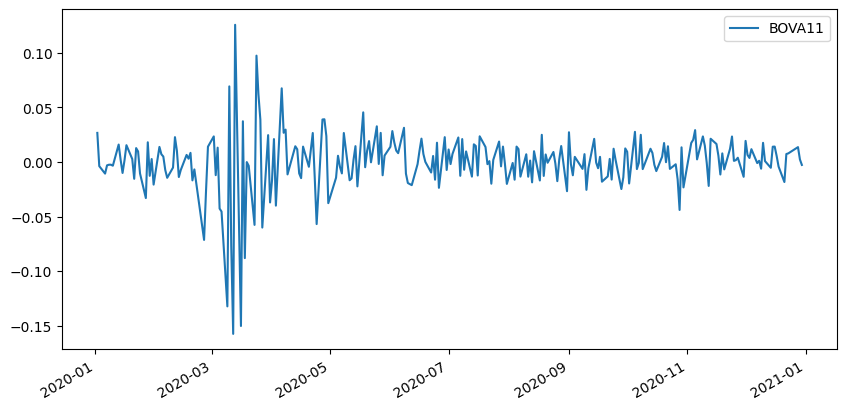

In [ ]:
brasa.get_returns("BOVA11", start=datetime(2020, 1, 1), end=datetime(2020, 12, 31)).plot(figsize=(10, 5))

In [ ]:
rets = brasa.get_returns("BOVA11", start=datetime(2021, 1, 1), end=datetime(2021, 12, 31))

In [ ]:
rets.loc[rets.BOVA11.isna()]

,BOVA11


In [ ]:
rets = brasa.get_returns(["DI1T252"], calendar="B3")
rets.loc[rets.DI1T252.isna()]

,DI1T252


In [ ]:
symbol = "PETR4"
rets = brasa.get_returns(symbol)
rets.loc[rets[symbol].isna()]

,PETR4


,DIVO11
2012-02-15,NaN
2012-02-16,NaN
2012-02-17,NaN
2012-02-22,NaN
2012-04-16,NaN
2012-04-17,NaN


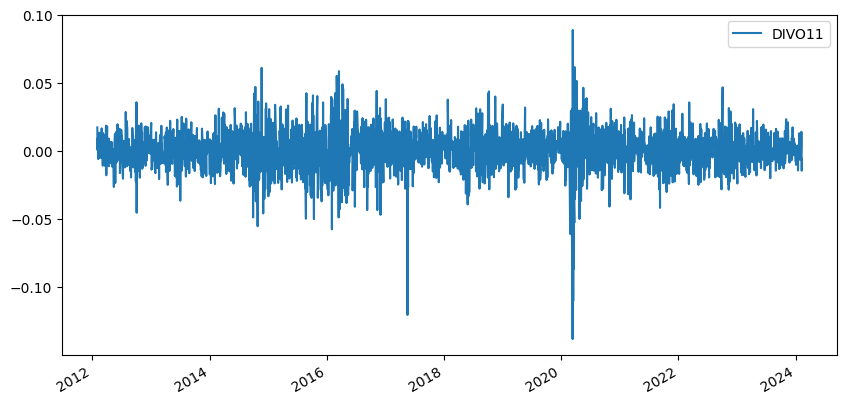

In [ ]:
symbol = "DIVO11"
rets = brasa.get_returns(symbol)
rets.plot(figsize=(10, 5))
rets.loc[rets[symbol].isna()]

In [ ]:
symbols = brasa.get_symbols("equity", index="SMLL")

<Axes: >

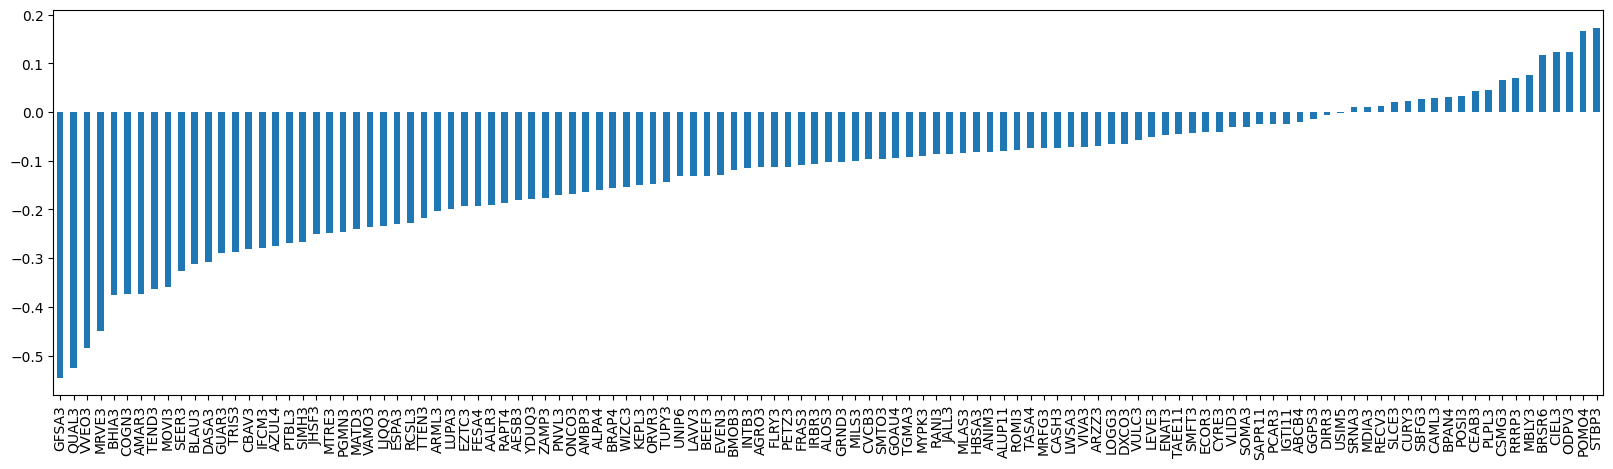

In [ ]:
brasa.get_returns(symbols, start=datetime(2024, 1, 1)).sum().sort_values().plot(kind="bar", figsize=(20, 5))

In [ ]:
brasa.get_dataset("b3-bvbg028-equities").filter(pc.field("refdate") == datetime(2024, 1, 31)).to_table().to_pandas()

,creation_date,refdate,security_id,security_proprietary,security_market,instrument_asset,instrument_asset_description,instrument_market,instrument_segment,instrument_description,...,ex_distribution_number,custody_treatment_type,trading_currency,market_capitalisation,close,open,days_to_settlement,right_issue_price,instrument_type,governance_indicator
0,2024-01-31,2024-01-31,200001134279,8,BVMF,ATOM,ATOM,10,1,ATOMPAR ON,...,0,0.0,BRL,23804898,2.12,2.803977,2,0.0,EqtyInf,None
1,2024-01-31,2024-01-31,200000702285,8,BVMF,GZIT,GZIT,17,1,FII GAZIT CI,...,101,0.0,BRL,21173640,0.00,0.000000,2,0.0,EqtyInf,None
2,2024-01-31,2024-01-31,200000702302,8,BVMF,WRLD,WRLD,8,1,INVESTO WRLDCI,...,0,NaN,BRL,50000,NaN,NaN,1,0.0,EqtyInf,None
3,2024-01-31,2024-01-31,200000702290,8,BVMF,WRLD,WRLD,10,1,INVESTO WRLDCI,...,0,0.0,BRL,20000000,91.13,100.000000,2,0.0,EqtyInf,None
4,2024-01-31,2024-01-31,200000270372,8,BVMF,AMZG,AMZG,17,1,AMAZONAS ENEON,...,0,0.0,BRL,6276666628,0.00,0.000000,2,0.0,EqtyInf,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11058,2024-01-31,2024-01-31,200001133508,8,BVMF,IGTI,IGTI,20,1,IGUATEMI S.AUNT N1,...,0,0.0,BRL,218426590,23.70,19.145475,2,0.0,EqtyInf,N1
11059,2024-01-31,2024-01-31,200001133615,8,BVMF,BRIT,BRIT,20,1,BRISANET ON NM,...,0,0.0,BRL,449094916,2.99,2.147654,2,0.0,EqtyInf,NM
11060,2024-01-31,2024-01-31,200001133613,8,BVMF,BRIT,BRIT,10,1,BRISANET ON NM,...,0,0.0,BRL,449094916,2.99,2.147654,2,0.0,EqtyInf,NM
11061,2024-01-31,2024-01-31,200000269629,8,BVMF,CXTL,CXTL,10,1,"FII CX TRX DM 480,00",...,0,0.0,BRL,3340,0.00,0.000000,2,480.0,EqtyInf,None


In [ ]:
brasa.get_dataset("b3-bvbg086").filter(pc.field("creation_date") == datetime(2024, 1, 31)).to_table().to_pandas()

,creation_date,refdate,symbol,security_id,security_proprietary,security_market,trade_quantity,volume,open_interest,traded_contracts,...,nonregular_transactions_quantity,nonregular_traded_contracts,nonregular_volume,oscillation_percentage,adjusted_quote,adjusted_tax,previous_adjusted_quote,previous_adjusted_tax,variation_points,adjusted_value_contract
0,2024-01-31,2024-01-31,XRXB34,200001348854,8,BVMF,1.0,95.00,NaN,1.0,...,NaN,NaN,NaN,-1.67,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-31,2024-01-31,IDIH24C387800,100000194648,8,BVMF,NaN,NaN,86.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-31,2024-01-31,IDIF25C432000,200001131920,8,BVMF,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-31,2024-01-31,VALEL749,200001140050,8,BVMF,2.0,4058.00,34000.0,500.0,...,NaN,NaN,NaN,-1.09,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-31,2024-01-31,BHIAO810,200001363659,8,BVMF,NaN,NaN,2100.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33150,2024-01-31,2024-02-01,CCMU24,200001038816,8,BVMF,11.0,374634.00,40192.0,13.0,...,NaN,NaN,NaN,-0.52,64.29,NaN,63.74,NaN,0.55,247.5000
33151,2024-01-31,2024-02-01,CCMX24,100000202730,8,BVMF,11.0,327775.50,6888.0,11.0,...,NaN,NaN,NaN,-0.45,66.40,NaN,66.38,NaN,0.02,9.0000
33152,2024-01-31,2024-02-01,ETHG24,100000194572,8,BVMF,1.0,690000.00,1224.0,10.0,...,NaN,NaN,NaN,1.32,2300.50,NaN,2270.00,NaN,30.50,915.0000
33153,2024-01-31,2024-02-01,ICFH24,100000181776,8,BVMF,1.0,117571.63,3863.0,1.0,...,NaN,NaN,NaN,0.00,237.85,NaN,237.20,NaN,0.65,321.3015


In [ ]:
brasa.get_dataset("b3-equity-symbols-properties").filter(pc.field("symbol").isin(symbols)).to_table().to_pandas()

,symbol,asset_name,trading_name,company_name,code_cvm,isin,sector,subsector,segment,stock_type
0,AALR3,AALR,ALLIAR,ALLIANÇA SAÚDE E PARTICIPAÇÕES S.A.,24058,BRAALRACNOR6,Saúde,Serv.Méd.Hospit..Análises e Diagnósticos,Serv.Méd.Hospit..Análises e Diagnósticos,ON
1,ABCB4,ABCB,ABC BRASIL,BCO ABC BRASIL S.A.,20958,BRABCBACNPR4,Financeiro,Intermediários Financeiros,Bancos,PN
4,AESB3,AESB,AES BRASIL,AES BRASIL ENERGIA S.A.,25640,BRAESBACNOR7,Utilidade Pública,Energia Elétrica,Energia Elétrica,ON
8,AGRO3,AGRO,BRASILAGRO,BRASILAGRO - CIA BRAS DE PROP AGRICOLAS,20036,BRAGROACNOR7,Consumo não Cíclico,Agropecuária,Agricultura,ON
14,ALOS3,ALOS,ALLOS,ALLOS S.A,22357,BRALOSACNOR5,Financeiro,Exploração de Imóveis,Exploração de Imóveis,ON
...,...,...,...,...,...,...,...,...,...,...
597,VULC3,VULC,VULCABRAS,VULCABRAS S.A.,11762,BRVULCACNOR2,Consumo Cíclico,Tecidos. Vestuário e Calçados,Calçados,ON
598,VVEO3,VVEO,VIVEO,CM HOSPITALAR S.A.,25682,BRVVEOACNOR0,Saúde,Comércio e Distribuição,Medicamentos e Outros Produtos,ON
603,WIZC3,WIZC,WIZ CO,WIZ CO PARTICIPAÇÕES E CORRETAGEM DE SEGUROS S.A.,23590,BRWIZCACNOR5,Financeiro,Previdência e Seguros,Corretoras de Seguros e Resseguros,ON
609,YDUQ3,YDUQ,YDUQS PART,YDUQS PARTICIPACOES S.A.,21016,BRYDUQACNOR3,Consumo Cíclico,Diversos,Serviços Educacionais,ON


In [ ]:
cvm_codes_fail = [
    183,
    1201,
    1270,
    4324,
    11479,
    12122,
    16217,
    16950,
    17752,
    20052,
    21687,
    22047,
    22586,
    26549,
    26700,
    504122,
    916502,
    917568,
]
brasa.get_dataset("b3-companies-info").filter(pc.field("code_cvm").isin(cvm_codes_fail)).to_table().to_pandas()

,asset_name,refdate,stock_capital,quoted_per_shar_since,common_shares_form,preferred_shares_form,has_common,has_preferred,round_lot,trading_name,number_common_shares,number_preferred_shares,total_number_shares,code_cvm,segment
0,AGRA,2024-01-17,1.265664e+08,1994-07-04,Escritural,Escritural,True,True,100000,AGRALE,41702073964,262916100,41964990064,183,BOLSA
1,BEGB,2024-01-17,1.644499e+08,1994-07-04,Nominativa,Nominativa,True,True,100000,BERJ BANCO,20111093543,14692904718,34803998261,1201,BOLSA
2,CEAL,2024-01-20,1.000000e+00,2023-04-13,Nominativa,,False,False,100,CEAL,677858321,0,689524384,917568,MB
3,CEAP,2024-01-17,1.000000e+00,2022-01-07,Nominativa,,False,False,100,CEA AMAPA,1117875640,0,1117875640,916502,MB
4,CLNT,2024-01-31,1.809976e+08,2022-03-04,Escritural,,True,False,100,CLARANET,118743,0,118743,26549,BOLSA
5,DNEN,2024-01-17,1.102380e+07,2006-07-31,Escritural,,True,False,100,DINAMICA ENE,334424444,0,334424444,20052,MB
6,DXXI,2024-01-17,2.089432e+07,2010-06-04,Escritural,Escritural,True,True,1000,DUXXI,11730803,0,11730803,22047,BOLSA
7,ELBR,2024-01-20,1.575399e+07,1994-07-04,Nominativa,Nominativa,False,False,10000,ELEBRA,35172269,70344536,105516805,12122,BOLSA
8,EUFA,2024-01-17,1.203878e+09,2022-07-19,Escritural,,True,False,100,EUROFARMA SA,987568073,0,987568073,26700,M2
9,IVLG,2024-01-20,2.000000e+06,2008-11-13,Escritural,,True,False,1000,INVIT LEGACY,1587353356,0,1587353356,21687,MB
